# Import Libraries

In [1]:
import datetime
import os
import time
import zipfile
from tqdm import tqdm
import torch

import requests
import yaml
import numpy as np
import pandas as pd

C:\Users\yuins\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



# Set path

In [2]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [3]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name, select=False):
    # temp
    if not select:
        temp = name+'_temperature'
        output = [temp]
    else:
        output = []
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    if not select:
        acceleration6 = name+'_3D_acceleration_6'
        acceleration6 = generate_three_IMU(acceleration6)
        output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    if not select:
        magnometer = name+'_3D_magnetometer'
        magnometer = generate_three_IMU(magnometer)
        output.extend(magnometer)
    # oreintation
    if not select:
        oreintation = name+'_4D_orientation'
        oreintation = generate_four_IMU(oreintation)
        output.extend(oreintation)
    return output

def select_IMU():
    output = ['time_stamp','activity_id']
    hand = 'hand'
    hand = generate_cols_IMU(hand, select=True)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest, select=True)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle, select=True)
    output.extend(ankle)
    # print(output)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)

    return output

In [4]:
def load_subjects(root='./data/raw/pamap2/PAMAP2_Dataset/Protocol/subject'):
    output = pd.DataFrame()
#     output = []
    cols = load_IMU()
    col_selected = select_IMU()
    
    for i in range(101,110):
        print(i)
        if i in [103, 109]:
            continue
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        # print(subject.columns)
        # print(col_selected)
        subject = subject[col_selected]
        subject['id'] = i
        output = pd.concat([output, subject], axis=0)
#         output = output.append(subject)
#     output = pd.DataFrame(output)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

101
102
103
104
105
106
107
108
109


In [5]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [6]:
data

,time_stamp,activity_id,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,...,chest_3D_gyroscope_x,chest_3D_gyroscope_y,chest_3D_gyroscope_z,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id
2928,37.66,1,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,0.124482,9.65003,...,0.036668,0.016559,-0.052791,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,101
2929,37.67,1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,0.200711,9.64980,...,0.019343,-0.024304,-0.059843,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,101
2930,37.68,1,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,0.270277,9.72331,...,-0.001428,0.038466,-0.046464,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,101
2931,37.69,1,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,0.236737,9.72447,...,0.017277,-0.048547,-0.074946,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,101
2932,37.70,1,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,0.352225,9.72437,...,0.000275,-0.013352,-0.039315,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591440,3888.37,24,-1.56754,-9.74184,-1.75943,-0.020359,-0.035195,0.028082,-0.114847,9.94938,...,0.157912,0.039918,-0.128307,9.11577,-0.294388,-3.664060,0.119553,-0.046894,-0.102102,108
2591441,3888.38,24,-1.63804,-9.58850,-1.64554,-0.030335,-0.041118,0.031938,-0.213206,9.79409,...,0.202302,0.136715,-0.126531,9.15729,-0.143714,-3.548800,0.099501,-0.089781,-0.078137,108
2591442,3888.39,24,-1.79054,-9.58767,-1.68632,-0.009027,-0.019017,0.031259,-0.155400,9.45975,...,0.105023,0.079569,-0.145507,9.33192,-0.217303,-3.971040,0.086514,-0.041586,-0.096625,108
2591443,3888.40,24,-1.64687,-9.51497,-1.91533,-0.034688,-0.069075,0.021787,0.142085,9.39061,...,0.055811,-0.023467,-0.126592,9.22334,-0.141619,-3.856850,0.036153,-0.020759,-0.067416,108


![image.png](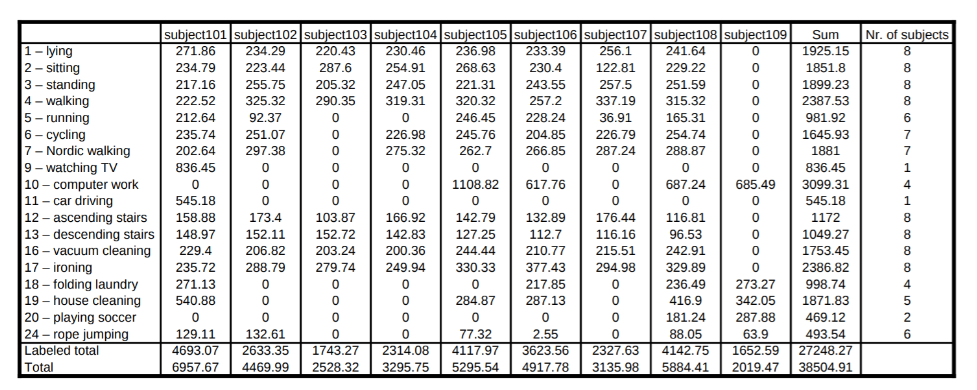!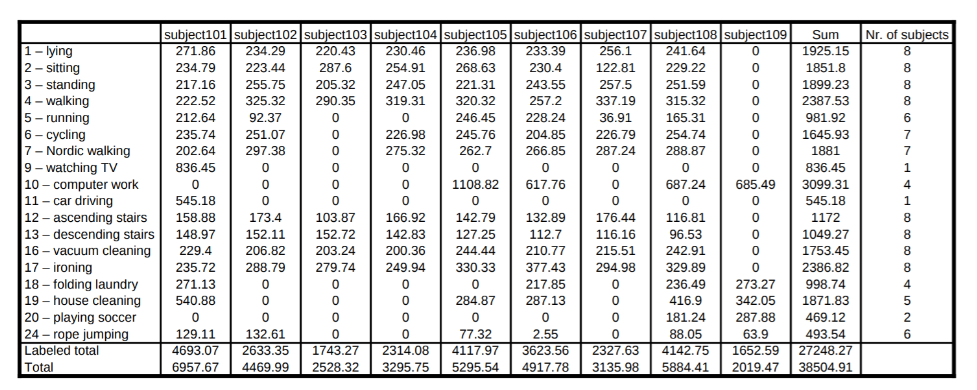[image.png](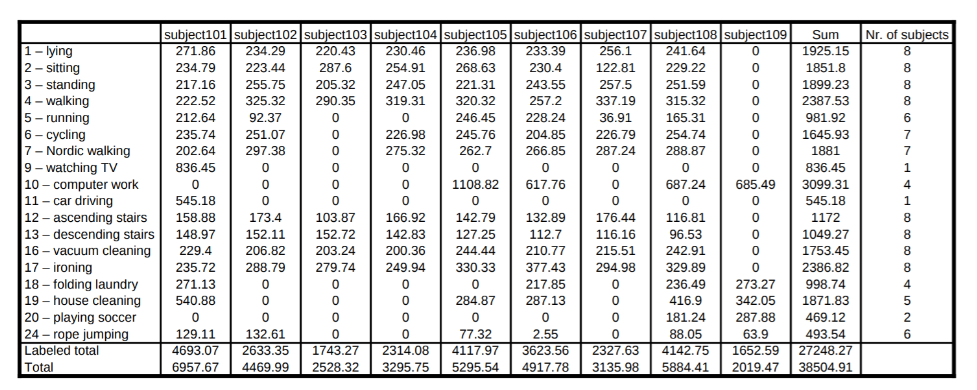))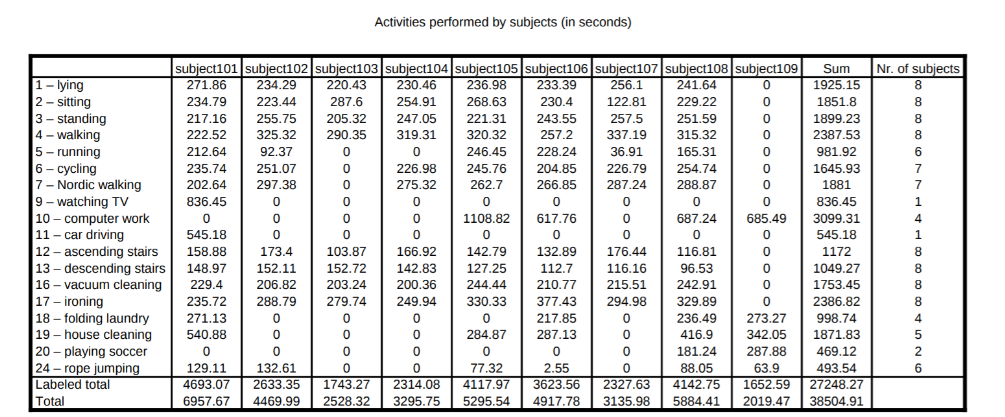

In [7]:
data = data.drop(data[data["activity_id"].isin([2, 5,9,10,11,12,13,18,10,20,24])].index)

In [8]:
res_dict = {num : [] for num in [1, 3, 4, 6, 7, 16, 17]}
for id in range(101,110):
    if id in [103, 109]:
        continue
    for activity_id in [1, 3, 4, 6, 7, 16, 17]:
        cnt = 0
        tmp = data[data.id == id]
        tmp2 = tmp[tmp.activity_id == activity_id]
        tmp3 = tmp2.drop(columns = ["time_stamp", "activity_id", "id"]).reset_index()
        res_dict[activity_id].append(tmp3.values.tolist())

In [9]:
res_dict = {num : [] for num in range(36)} #num : sample 개수
res_target_dict =  {num : [] for num in range(36)} #num : sample 
res_dict_test = {num2 : [] for num2 in range(14)} #num : sample 개수
res_target_dict_test =  {num2 : [] for num2 in range(14)} #num : sample 개수
cnt = 0
cnt2 = 0
for id in range(101,110):
    if id in [103, 109]: # 107, 108: test
        continue
    if id in [107, 108]: # test
        for activity_id in [1, 3, 4, 6, 7, 16, 17]:
            tmp = data[data.id == id]
            tmp2 = tmp[tmp.activity_id == activity_id]
            tmp3 = tmp2.drop(columns = ["time_stamp", "activity_id", "id"]).T.reset_index()
            res_dict_test[cnt2].append(np.array(tmp3.values.tolist()))
            res_target_dict_test[cnt2].append(activity_id)
            cnt2 +=1
    else: # train
        for activity_id in [1, 3, 4, 6, 7, 16, 17]:
            tmp = data[data.id == id]
            tmp2 = tmp[tmp.activity_id == activity_id]
            tmp3 = tmp2.drop(columns = ["time_stamp", "activity_id", "id"]).T.reset_index()
            res_dict[cnt].append(np.array(tmp3.values.tolist()))
            res_target_dict[cnt].append(activity_id)
            cnt +=1

In [10]:
len(res_target_dict_test.keys())

14

In [11]:
import pickle
with open('./data/pickles/PAMAP2_feature.pickle','wb') as fw:
    pickle.dump(res_dict, fw)
with open('./data/pickles/PAMAP2_target.pickle','wb') as ff:
    pickle.dump(res_target_dict, ff)
with open('./data/pickles/PAMAP2_feature_test.pickle','wb') as fw:
    pickle.dump(res_dict_test, fw)
with open('./data/pickles/PAMAP2_target_test.pickle','wb') as ff:
    pickle.dump(res_target_dict_test, ff)

